# Proyecto 1 – Atención de Incidentes  
## Tarea 4 – Modelamiento

Exploración de variables a incluir en el modelo.

Importamos las librerias a usar.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

Creamos función para análisis de variables a usar.


 Top 10 correlaciones más altas:
   1. incident_state_Closed ↔ active_True: -1.000
   2. impact_3 - Low ↔ priority_4 - Low: +0.975
   3. urgency_3 - Low ↔ priority_4 - Low: +0.943
   4. impact_3 - Low ↔ urgency_3 - Low: +0.915
   5. urgency_2 - Medium ↔ priority_3 - Moderate: +0.899
   6. contact_type_Phone ↔ contact_type_Self service: -0.891
   7. impact_2 - Medium ↔ priority_3 - Moderate: +0.883
   8. impact_2 - Medium ↔ urgency_2 - Medium: +0.749
   9. contact_type_Email ↔ notify_Send Email: +0.735
  10. impact_2 - Medium ↔ impact_3 - Low: -0.717

 Top 10 variables con mayor varianza:
   1. sys_mod_count: 58.99
   2. reassignment_count: 3.01
   3. u_priority_confirmation_True: 0.21
   4. incident_state_Active: 0.20
   5. incident_state_New: 0.19
   6. incident_state_Resolved: 0.15
   7. knowledge_True: 0.15
   8. active_True: 0.15
   9. incident_state_Closed: 0.15
  10. incident_state_Awaiting User Info: 0.09

Generando visualizaciones...


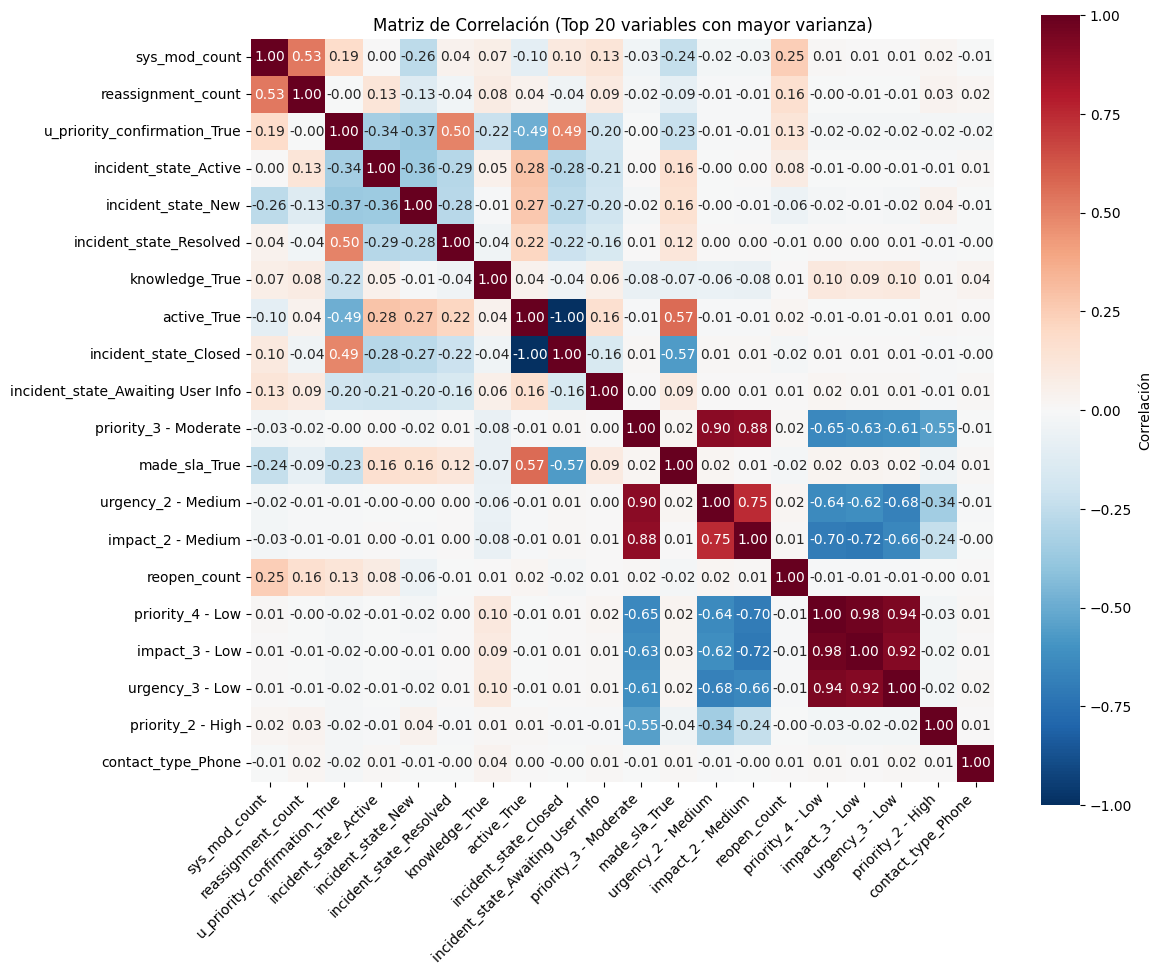

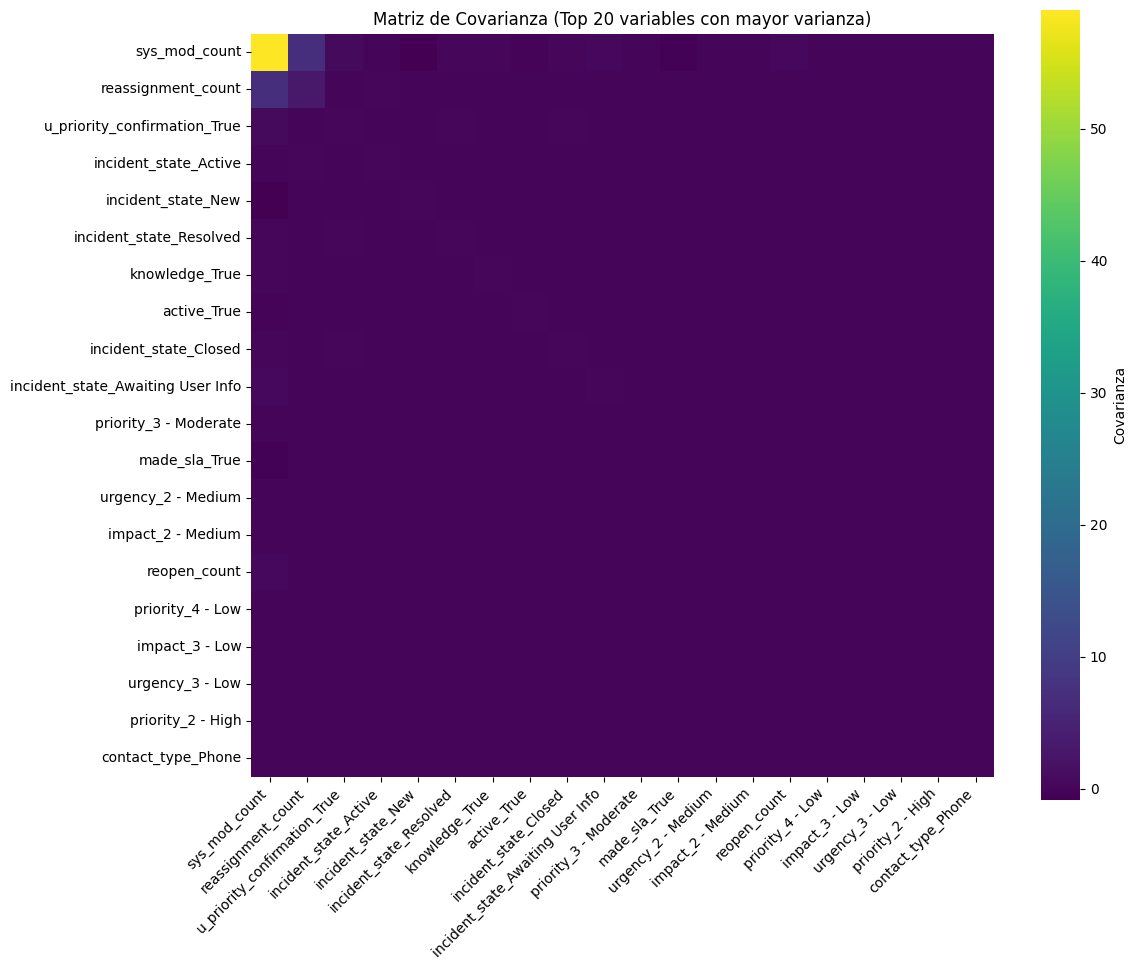

In [3]:
def optimized_covariance_analysis(csv_file_path="incident_event_log.csv"):
    """
    Análisis optimizado de covarianza para el dataset incident_event_log.csv
    Se enfoca solo en variables relevantes para evitar problemas de memoria
    """
    
    df = pd.read_csv(csv_file_path)
    
    # Variables que SÍ vamos a procesar. 
    variables_to_process = ['incident_state', 'active', 'reopen_count', 'made_sla', 'contact_type', 'impact', 'urgency', 'priority', 'knowledge', 'u_priority_confirmation',
                            'notify', 'reassignment_count', 'sys_mod_count']
    
    # Variables que NO vamos a procesar (alta cardinalidad o irrelevantes para covarianza)
    excluded_vars = ['number', 'caller_id', 'opened_by', 'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by', 'sys_updated_at', 'location', 'category', 'subcategory',
                     'u_symptom', 'cmdb_ci', 'assignment_group', 'assigned_to', 'problem_id', 'rfc', 'resolved_by', 'resolved_at', 'closed_at', 'vendor', 'caused_by', 'closed_code']
    
    # Crear dataset filtrado
    df_filtered = df[variables_to_process].copy()
    
    # Manejar valores faltantes
    missing_data = df_filtered.isnull().sum()
    if missing_data.sum() > 0:
        # Rellenar valores faltantes
        for col in df_filtered.columns:
            if df_filtered[col].isnull().sum() > 0:
                if df_filtered[col].dtype == 'object' or df_filtered[col].dtype == 'bool':
                    # Para categóricas, usar la moda
                    mode_value = df_filtered[col].mode()
                    if len(mode_value) > 0:
                        df_filtered[col].fillna(mode_value[0], inplace=True)
                    else:
                        df_filtered[col].fillna('Unknown', inplace=True)
                else:
                    # Para numéricas, usar la mediana
                    df_filtered[col].fillna(df_filtered[col].median(), inplace=True)
    
    # Identificar variables categóricas vs numéricas
    categorical_vars = []
    numerical_vars = []
    
    for col in df_filtered.columns:
        if df_filtered[col].dtype in ['object', 'bool']:
            categorical_vars.append(col)
        else:
            numerical_vars.append(col)
    
    # Convertir variables categóricas a dummies
    df_processed = df_filtered.copy()
    
    for var in categorical_vars:
        
        # Crear dummies
        dummies = pd.get_dummies(df_filtered[var], prefix=var, drop_first=True)
        
        # Agregar al dataset
        df_processed = pd.concat([df_processed, dummies], axis=1)
        
        # Eliminar variable original
        df_processed.drop(var, axis=1, inplace=True)
    
    
    # Calcular matrices de covarianza y correlación
    # Matriz de covarianza
    covariance_matrix = df_processed.cov()
    
    # Matriz de correlación
    correlation_matrix = df_processed.corr()
    
    
    # Crear matriz triangular superior
    correlation_upper = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # Encontrar correlaciones significativas
    high_correlations = []
    for col in correlation_upper.columns:
        for idx in correlation_upper.index:
            value = correlation_upper.loc[idx, col]
            if pd.notna(value) and abs(value) > 0.1:  # Umbral bajo para encontrar más correlaciones
                high_correlations.append((idx, col, value))
    
    # Ordenar por correlación absoluta
    high_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"\n Top 10 correlaciones más altas:")
    for i, (var1, var2, corr) in enumerate(high_correlations[:10]):
        print(f"  {i+1:2d}. {var1} ↔ {var2}: {corr:+.3f}")
    
    # Variables con mayor varianza
    variances = df_processed.var().sort_values(ascending=False)
    print(f"\n Top 10 variables con mayor varianza:")
    for i, (var, variance) in enumerate(variances.head(10).items()):
        print(f"  {i+1:2d}. {var}: {variance:.2f}")
    
    # Crear visualizaciones
    print(f"\nGenerando visualizaciones...")
    
    # Heatmap de correlación (top 20 variables con mayor varianza)
    top_vars = variances.head(20).index
    corr_subset = correlation_matrix.loc[top_vars, top_vars]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_subset, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                vmin=-1, vmax=1,
                square=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlación'})
    plt.title('Matriz de Correlación (Top 20 variables con mayor varianza)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Heatmap de covarianza
    cov_subset = covariance_matrix.loc[top_vars, top_vars]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cov_subset, 
                annot=False, 
                cmap='viridis', 
                square=True,
                cbar_kws={'label': 'Covarianza'})
    plt.title('Matriz de Covarianza (Top 20 variables con mayor varianza)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    
    # Resumen
    summary = {
        'Variables_Originales': len(df.columns),
        'Variables_Procesadas': len(variables_to_process),
        'Variables_Excluidas': len(excluded_vars),
        'Variables_Categoricas': len(categorical_vars),
        'Variables_Numericas': len(numerical_vars),
        'Variables_Finales_Dummies': df_processed.shape[1],
        'Filas_Procesadas': df_processed.shape[0],
        'Dimension_Matriz_Covarianza': f"{covariance_matrix.shape[0]}x{covariance_matrix.shape[1]}",
        'Correlaciones_Significativas': len([x for x in high_correlations if abs(x[2]) > 0.3])
    }
    
    return {
        'processed_data': df_processed,
        'covariance_matrix': covariance_matrix,
        'correlation_matrix': correlation_matrix,
        'high_correlations': high_correlations,
        'variances': variances,
        'summary': summary
    }

if __name__ == "__main__":
    # Ejecutar análisis
    results = optimized_covariance_analysis("incident_event_log.csv")